
# Headers



In [1]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import pdb


# Utility Functions



In [2]:
# Functions for initialization

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '_LPAREN_')
    name = name.replace(']', '_RPAREN_')
    name = name.replace('(', '_LPAREN_')
    name = name.replace(')', '_RPAREN_')
    return name

def defineDFBAModel(SpeciesDict , MediaDF):
    print("Defining Dynamical model... \n")
    ParDef = dict()
    VarDef = dict()
    ICS = dict()
    exchange_list = []
    mediaDerivedComponents = {}
    for i, row in MediaDF.iterrows():
        N = cleanupname(row.Reaction)
        mediaDerivedComponents[N] = row['Flux Value'] / (24.0*60.0) # Per minute

    for species in SpeciesDict.keys():
        SpeciesDict[species]['SpeciesModel'] = cobra.io.read_sbml_model(SpeciesDict[species]['File'])
        SpeciesDict[species]['OriginalLB'] = {r.id:r.lower_bound for r in SpeciesDict[species]['SpeciesModel'].exchanges}
        SpeciesDict[species]['solution'] = SpeciesDict[species]['SpeciesModel'].optimize()
        SpeciesDict[species]['Name'] = SpeciesDict[species]['SpeciesModel'].name.split(' ')[0]
        exchange_list += SpeciesDict[species]['SpeciesModel'].exchanges
        Name=SpeciesDict[species]['Name']
        ParDef['mu' + '_' + Name] = SpeciesDict[species]['solution'].objective_value/60
        VarDef[Name] =  'mu_' + Name + ' * ' + Name + '- ' +'Dilution * ' + Name ### Biomass
        ICS[Name] = SpeciesDict[species]['initAbundance']
    ParDef['Dilution'] = 0.002
    all_exchanges = set()

    for ex in exchange_list:
        all_exchanges.add(ex.id)
        #     all_exchanges = list(set(exchange_list))

    for rid in all_exchanges:
        VarDef[rid] =  '-Dilution * ' + rid
        ICS[rid] = 0.1

        if rid in mediaDerivedComponents.keys():
            ParDef[rid + '_influx'] = mediaDerivedComponents[rid]
            VarDef[rid] += ' + ' +  rid + '_influx'

        for species in SpeciesDict.keys():
            # print(SpeciesDict[species]['Name'])
            if 'h2o' in rid:
                print(species, rid)
            if rid in [species_r.id for species_r in SpeciesDict[species]['SpeciesModel'].exchanges]:
                Name = SpeciesDict[species]['Name']
                ParDef[rid + '_' + Name] = SpeciesDict[species]['solution'].fluxes[rid]/60.0
                VarDef[rid] += ' + ' +  rid + '_' + Name + ' * ' + Name

    ModelDef = dst.args(name='Community',
                    pars=ParDef,
                        varspecs=VarDef,
                        ics=ICS)
    ModelDS = dst.Vode_ODEsystem(ModelDef)
    print("Done!")
    return (SpeciesDict, ModelDef, ModelDS)

# Functions for model updates

def recomputeLowerBounds(SpeciesDict, PrevSteadyState, Kmax):
    for species in SpeciesDict.keys():
        for rid in [rxn.id for rxn in SpeciesDict[species]['SpeciesModel'].exchanges]:
            SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid) \
                                                   .lower_bound = \
                                                                  SpeciesDict[species]['OriginalLB'][rid] \
                                                                  * PrevSteadyState[rid]/(Kmax+PrevSteadyState[rid])
    return SpeciesDict

def updateFluxParameters(SpeciesDict, ModelDS, PrevSteadyState):
    ParDef = {}
    ICS = {}
    for species in SpeciesDict:
        solution = SpeciesDict[species]['SpeciesModel'].optimize()
        Name = SpeciesDict[species]['Name']
        ParDef['mu_' + Name] = solution.objective_value/60.0
        ICS[Name] = PrevSteadyState[Name]
        exchanges = [r.id for r in SpeciesDict[species]['SpeciesModel'].exchanges]
        for rid in exchanges:
            ParDef[rid + '_' + Name] = solution.fluxes[rid]/60.0
            ICS[rid] = PrevSteadyState[rid]
    ModelDS.set(pars=ParDef, ics=ICS)
    return ModelDS

def update(SpeciesDict, ModelDS, PrevSteadyState, Kmax):
    UpdatedSpeciesDict = recomputeLowerBounds(SpeciesDict,
                                              PrevSteadyState, Kmax)

    UpdatedDynamicModel = updateFluxParameters(UpdatedSpeciesDict,
                                               ModelDS,
                                               PrevSteadyState)
    # P = simulateModel(updatedDynamicalModel)
    return(UpdatedSpeciesDict, UpdatedDynamicModel)

def get_ss(PointSet):
    SSPoints={}
    for k in PointSet.keys():
        SSPoints[k]=PointSet[k][-1]
    return(SSPoints)

def checkNegativeMetabolites(PointSet,StoreNegatives):
    metname = 'EX_h2o__40__e__41__'
    IndexStop = len(PointSet['t']) - 1

    for variable in PointSet.keys():
        if PointSet[variable][-1] < 0.0: # checking only final Tpoint, b/c monotonic
            varIndex = next((index for index,value in enumerate(PointSet[variable]) if value < 0), None)
            if varIndex < IndexStop:
                # Update the index for the first negative crossing
                IndexStop = varIndex

    if IndexStop < len(PointSet['t']) - 1 and IndexStop > 0:
        P_tilFirstNeg={}
        for variable in PointSet.keys():
            P_tilFirstNeg[variable]=P[variable][:IndexStop]
            if PointSet[variable][IndexStop] < 0:
                P_tilFirstNeg[variable][IndexStop-1] = 0
                StoreNegatives.add(variable)
                print(variable, 'is 0 at ', P['t'][IndexStop])
        P_tilFirstNeg['t'] = PointSet['t'][:IndexStop]
        PointSet = P_tilFirstNeg
    return(PointSet,StoreNegatives)


# Test:



In [3]:
# SpeciesDict = {'Sp1': {'File': './data/Bacteroides_sp_1_1_14.xml', 'initAbundance': 0.01},
#  'Sp10': {'File': './data/Desulfovibrio_piger_ATCC_29098.xml',
#   'initAbundance': 0.01},
#  'Sp2': {'File': './data/Ruminococcus_flavefaciens_FD_1.xml',
#   'initAbundance': 0.01},
#  'Sp3': {'File': './data/Lactobacillus_brevis_ATCC_367.xml',
#   'initAbundance': 0.01},
#  'Sp4': {'File': './data/Mycobacterium_avium_subsp_avium_ATCC_25291.xml',
#   'initAbundance': 0.01},
#  'Sp5': {'File': './data/Actinomyces_viscosus_C505.xml',
#   'initAbundance': 0.01},
#  'Sp6': {'File': './data/Exiguobacterium_aurantiacum_DSM_6208.xml',
#   'initAbundance': 0.01},
#  'Sp7': {'File': './data/Arcanobacterium_haemolyticum_DSM_20595.xml',
#   'initAbundance': 0.01},
#  'Sp8': {'File': './data/Streptococcus_intermedius_JTH08.xml',
#   'initAbundance': 0.01},
#  'Sp9': {'File': './data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
#   'initAbundance': 0.01}}
SpeciesDict = {'Sp1': {'File':'./data/Bacteroides_sp_1_1_14.xml',
                      'initAbundance':2e-2},
#                'Sp2': {'File':'./data/Actinomyces_viscosus_C505.xml',
#                        'initAbundance':2e-2},
               'Sp3': {'File':'./data/Bifidobacterium_longum_infantis_ATCC_15697.xml',
                       'initAbundance':2e-2},
               'Sp4': {'File':'./data/Desulfovibrio_piger_ATCC_29098.xml',
                      'initAbundance':2e-2},
}
MediaDF = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

SpeciesDict, Definition, ModelDS = defineDFBAModel(SpeciesDict, MediaDF)
InitialValues = {k:[v] for (k,v) in Definition.ics.items()}

Defining Dynamical model... 

Sp4 EX_h2o__40__e__41__
Sp1 EX_h2o__40__e__41__
Sp3 EX_h2o__40__e__41__
Done!


In [4]:
AllPoints = []
StoreNegatives = set()
P = InitialValues
T0=0
TEND = 1000
TSPAN = 100
Kmax=0.01
IndexStop = len(P['EX_h2o__40__e__41__'])
i=0
MaxIter= 30
TERMINATE = False
while T0 < TEND and i < MaxIter:
#and not TERMINATE:
    i+=1
    print(T0)
    print(P['EX_gln_L__40__e__41__'][-1])
    SpeciesDict, ModelDS = update(SpeciesDict, ModelDS, get_ss(P), Kmax)

    if T0+TSPAN > TEND:
        TSPAN = TEND - T0

    ModelDS.set(tdata=[T0, T0 + TSPAN])
    P = ModelDS.compute('test').sample() 

    # Initialize
    P, StoreNegatives = checkNegativeMetabolites(P,StoreNegatives) 
    T0 = P['t'][-1]
#     if len(P['t']) != 0:
#         T0 = P['t'][-1]
#     else:
#         TERMINATE = True

    AllPoints.append(P)

0
0.1
EX_h2o__40__e__41__ is 0 at  2.4702470247024704
2.4602460246024602
0.1026853350767234
EX_asp_L__40__e__41__ is 0 at  2.8502850285028503
2.84028402840284
0.103777999414311
EX_sucr__40__e__41__ is 0 at  3.4003400340034
3.3903390339033903
0.1036638949734714
EX_etoh__40__e__41__ is 0 at  3.8203820382038205
3.8103810381038103
0.10325531255234813
EX_h2o__40__e__41__ is 0 at  5.2205220522052205
EX_ser_L__40__e__41__ is 0 at  5.2205220522052205
5.210521052105211
0.10186045083787218
EX_fru__40__e__41__ is 0 at  6.020602060206021
6.010601060106011
0.10169758815516208
EX_h2o__40__e__41__ is 0 at  6.590659065906591
6.580658065806581
0.10158170738217229
EX_h2o__40__e__41__ is 0 at  6.590659065906591
6.580658065806581
0.10158170738217229
EX_h2o__40__e__41__ is 0 at  6.590659065906591
6.580658065806581
0.10158170738217229
EX_h2o__40__e__41__ is 0 at  6.590659065906591
6.580658065806581
0.10158170738217229
EX_h2o__40__e__41__ is 0 at  6.590659065906591
6.580658065806581
0.10158170738217229
EX_h2

KeyboardInterrupt: 

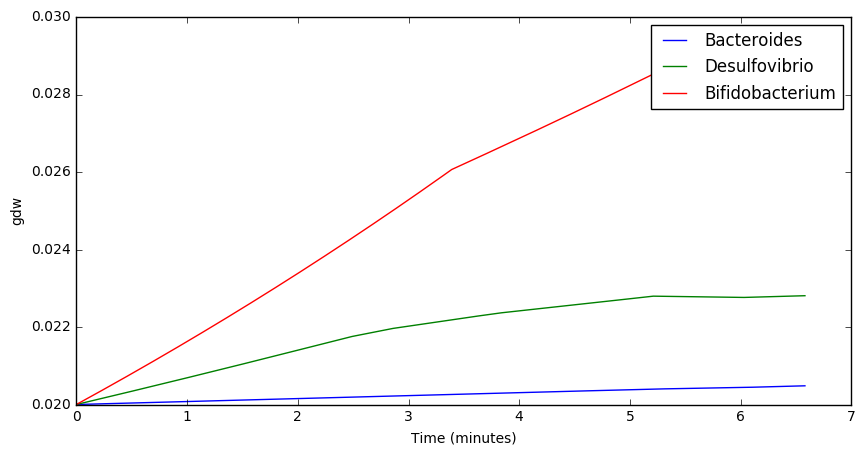

In [5]:
TimePoints={}
TimePoints['t'] =[]
plt.figure(figsize=(10,5))
for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for sp in SpeciesDict.keys():
    TimePoints[SpeciesDict[sp]['Name']] = []
    for P in AllPoints:
        TimePoints[SpeciesDict[sp]['Name']]+=list(P[SpeciesDict[sp]['Name']])

for k in TimePoints.keys():
    if k!= 't':
        plt.plot(TimePoints['t'], TimePoints[k], label=k)
        plt.xlabel('Time (minutes)')
        plt.ylabel('gdw')
plt.xlabel('Time (minutes)')
plt.ylabel('gdw')
plt.legend()

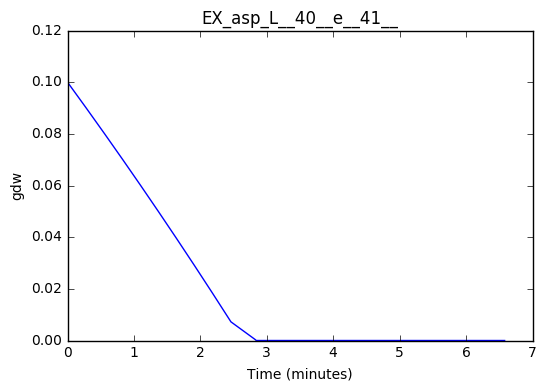

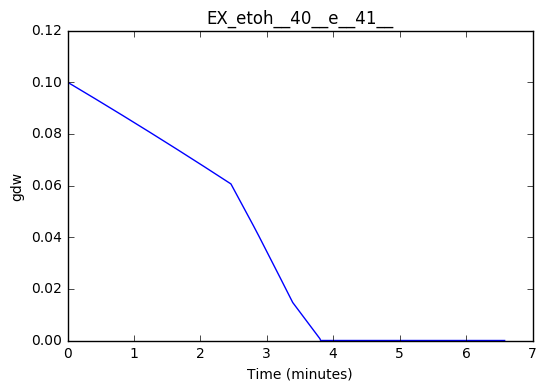

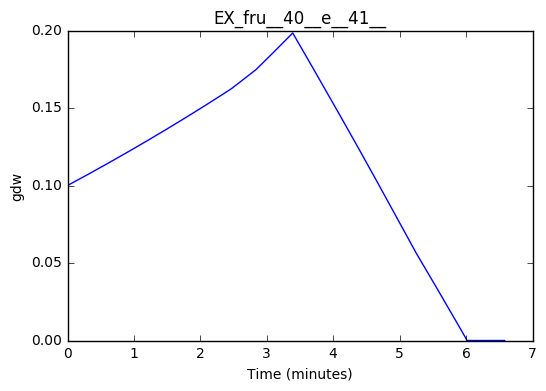

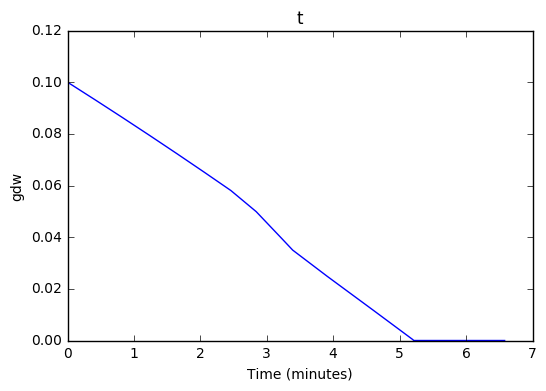

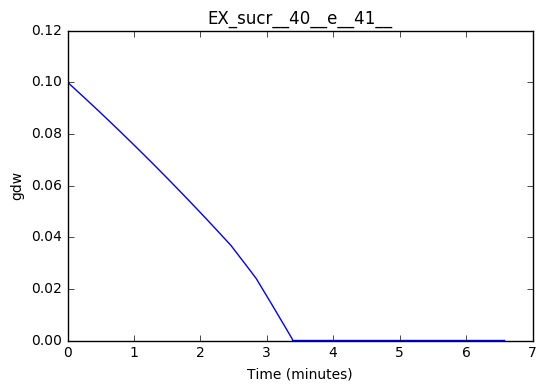

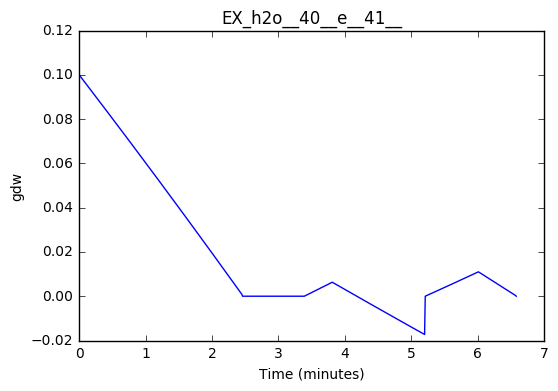

In [6]:
TimePoints={}
TimePoints['t'] =[]

for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for variable in StoreNegatives:
    TimePoints[variable] = []
    for P in AllPoints:
        TimePoints[variable]+=list(P[variable])

for k in TimePoints.keys():
    if k != 't':
        plt.figure()
        plt.plot(TimePoints['t'], TimePoints[k])
    plt.title(k)    
    plt.xlabel('Time (minutes)')
    #plt.ylim([0,0.5])
    plt.ylabel('gdw')

In [7]:
P

{'Bacteroides': array([0.02048243]),
 'Bifidobacterium': array([0.0296686]),
 'DM_4HBA': array([0.09869249]),
 'DM_clpn140__40__c__41__': array([0.09869249]),
 'DM_clpn160__40__c__41__': array([0.09869249]),
 'DM_clpn180__40__c__41__': array([0.09869249]),
 'DM_clpni16__40__c__41__': array([0.09869249]),
 'DM_dhptd__40__c__41__': array([0.09869249]),
 'DM_pheme__40__c__41__': array([0.09869249]),
 'Desulfovibrio': array([0.02280738]),
 'EX_12ppd_S__40__e__41__': array([0.09869249]),
 'EX_2obut__40__e__41__': array([0.09849203]),
 'EX_4hbz__40__e__41__': array([0.09869249]),
 'EX_7dhcdchol__40__e__41__': array([0.09869249]),
 'EX_7ocholate__40__e__41__': array([0.09869249]),
 'EX_C02528__40__e__41__': array([0.09869249]),
 'EX_Ser_Thr__40__e__41__': array([0.09869249]),
 'EX_T_antigen__40__e__41__': array([0.09869249]),
 'EX_Tn_antigen__40__e__41__': array([0.09869249]),
 'EX_ac__40__e__41__': array([0.36718009]),
 'EX_acald__40__e__41__': array([0.11598699]),
 'EX_acgal__40__e__41__': 

In [8]:
fname=['Bacteroides_sp_1_1_14', 
    'Ruminococcus_flavefaciens_FD_1',  
    'Lactobacillus_brevis_ATCC_367',  
    'Mycobacterium_avium_subsp_avium_ATCC_25291',  
    'Actinomyces_viscosus_C505',  
    'Exiguobacterium_aurantiacum_DSM_6208', 
    'Arcanobacterium_haemolyticum_DSM_20595',
    'Streptococcus_intermedius_JTH08',
    'Bifidobacterium_longum_infantis_ATCC_15697',
    'Desulfovibrio_piger_ATCC_29098']
count=1
d = {}
for f in fname:
    d['Sp' + str(count)] = {'File': './data/' + f +'.xml',
                            'initAbundance':1e-2}
    count +=1